In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

In [2]:
#run this first time
df_tot=None

In [3]:
#to run house hold, make the below variable True
run_hh=True

window=4
lstm_dim=100
input_size=5
train_ratio=0.76

if run_hh:
    batch_size=10
else:
    batch_size=3

In [18]:
tf.reset_default_graph()

#Input placeholders
tf_x=tf.placeholder(shape=[batch_size, window,input_size], dtype=tf.float32)
tf_y=tf.placeholder(shape=[batch_size, 1], dtype=tf.float32)
tf_y_his=tf.placeholder(shape=[batch_size, window], dtype=tf.float32)
is_training=tf.placeholder(shape=(), dtype=tf.bool)

#Define Encoder LSTM cell, and get states
cell=tf.nn.rnn_cell.BasicLSTMCell(lstm_dim)
# c,h = cell.zero_state(batch_size,dtype=tf.float32)
c,h = cell.zero_state(batch_size,dtype=tf.float32)

#Define attention weights and bias

attn_linear_wt=tf.get_variable('att_wts',shape=[2*lstm_dim+window,1])
attn_linear_b=tf.get_variable('att_b',shape=[batch_size*input_size,1])
# attn_linear_b=tf.Variable(shape=[batch_size,1,1], dtype=tf.float32)tf.get_variable("my_variable", [1, 2, 3])

input_weighted = []
input_encoded = []

for t in range(window):
    c_en= tf.expand_dims(c,0)
    h_en= tf.expand_dims(h,0)
    c_en=tf.tile(c_en,[input_size,1,1])
    h_en=tf.tile(h_en,[input_size,1,1])
    x= tf.concat([tf.transpose(tf_x,[0,2,1]),tf.transpose(c_en,[1,0,2]), tf.transpose(h_en,[1,0,2])], axis=2)
    x = tf.reshape(x,[-1,2*lstm_dim+window])
    x=tf.add(tf.matmul( x,attn_linear_wt),attn_linear_b)
    attn_weights = tf.nn.softmax(tf.reshape(x,[-1,input_size]), dim=1) 
    weighted_input = tf.multiply(attn_weights,tf_x[:, t, :])  # (batch_size, input_size)
    
    _, states = cell(weighted_input,(c,h))
    c=states[0]
    h=states[1]
    input_weighted.append(weighted_input)
    input_encoded.append(h)
    
cell_de=tf.nn.rnn_cell.BasicLSTMCell(lstm_dim)
c_de,h_de = cell_de.zero_state(batch_size,dtype=tf.float32)
attn_de_linear_wt=tf.get_variable('att_de_wts',shape=[3*lstm_dim,lstm_dim])
attn_de_linear_b=tf.get_variable('att_de_b',shape=[1,lstm_dim])
attn_de_linear_wt_1=tf.get_variable('att_de_wts_1', shape=[lstm_dim,1])
attn_de_linear_b_1=tf.get_variable('att_de_b_1', shape=[1,1])

fc_de_wt=tf.Variable(tf.zeros([2*lstm_dim,1]))
fc_de_b=tf.Variable(tf.zeros([1,1]))

fc_de_wt_fin=tf.Variable(tf.zeros([2*lstm_dim,1]))
fc_de_b_fin=tf.Variable(tf.zeros([1,1]))

for t in range(window):
    c_de_1= tf.expand_dims(c_de,0)
    h_de_1= tf.expand_dims(h_de,0)
    c_de_1 = tf.tile(c_de_1,[window,1,1])
    h_de_1 = tf.tile(h_de_1,[window,1,1])
    x= tf.concat([c_de_1,h_de_1,tf.reshape(input_encoded,[window, batch_size, lstm_dim])], axis=2)
    x=tf.reshape(x,[-1,3*lstm_dim])
    x= seq(x)
    x=tf.nn.softmax(tf.reshape(x,[-1,window]))
#     x = tf.layers.dropout(inputs=x, training=is_training, rate=0.4)
    t1=tf.reshape(input_encoded,[batch_size,window, lstm_dim])
    context = tf.matmul(tf.expand_dims(x,1), t1)[:, 0, :]
    y_m  = tf.tile(tf.reshape(tf_y_his[:,t],[-1,1]),[1,lstm_dim])
    conc = tf.concat([context, y_m], axis=1)
    y_tilde = tf.add(tf.matmul(conc,fc_de_wt), fc_de_b)
    _, states_de = cell_de(y_tilde, (c_de,h_de))
    c_de=states_de[0]
    h_de= states_de[1]
context = tf.layers.dropout(inputs=context, training=is_training, rate=0.5)
conc_fin=tf.concat([context, h_de], axis=1)
fc_final = tf.add(tf.matmul(conc_fin, fc_de_wt_fin), fc_de_b_fin)

loss = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(fc_final,tf_y))))

# loss=lossq(0.5,tf_y, fc_final)
# loss=lossq(0.9,tf_y, fc_final)
# loss=lossq(0.1,tf_y, fc_final)

opt=tf.train.AdamOptimizer()
training_op = opt.minimize(loss)

In [17]:
if run_hh:
    Xtrain_ss, Xtest_ss, ytrain_his_ss, ytest_his_ss, ytrain_ss, ytest_ss=get_household_data()
else:
    if df_tot is None:
        dfs=[]
        for i in range(0,12):
            df= pd.read_csv('D:/Time_Series_Data/data_20180322.tar/data_20180322/airstation_sensor_{}.csv'.format(i), '\t')
            dfs.append(df)
        df_tot = pd.concat(dfs,axis=0)
    df_tot, Xtrain_ss, Xtest_ss, ytrain_his_ss, ytest_his_ss, ytrain_ss, ytest_ss=get_air_ss_data(3, df_tot)


(1090, 4, 5)
(342, 4, 5)
(1090, 4)
(1090, 1)
(342, 4)
(342, 1)


D:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


In [ ]:
saver=tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(2000):
        ls=[]
        for a in range(0, Xtrain_ss.shape[0], batch_size):
            x_ss=Xtrain_ss[a:a+batch_size,:,:]
            if x_ss.shape[0]!=batch_size:
                continue
            y_his_ss=ytrain_his_ss[a:a+batch_size,:]
            y_ss=ytrain_ss[a:a+batch_size,:]
            _, l,yp = sess.run([training_op,loss,attn_linear_b], feed_dict={tf_x:x_ss, tf_y_his:y_his_ss, tf_y:y_ss, is_training:True})
            ls.append(l)
#             print(yp)
        if(e%50==0):
            print(np.mean(ls))
#             print(yp)
    if run_hh:
        saver.save(sess,'./da_rnn_hh.ckpt')
    else:
        saver.save(sess,'./da_rnn_air.ckpt')

1616.8799
1101.401
750.8376
631.2266
585.5498


In [201]:
with tf.Session() as sess:
    pred_test=[]
    pred_train=[]
    
    sess.run(tf.global_variables_initializer())
    if run_hh:
        saver.restore(sess,'./da_rnn_hh.ckpt')
    else:
        saver.restore(sess,'./da_rnn_air.ckpt')
    ls=[]
    for a in range(0, Xtest_ss.shape[0], batch_size):
        x_ss=Xtest_ss[a:a+batch_size,:,:]
        if(x_ss.shape[0]!=batch_size):
            continue
        y_his_ss=ytest_his_ss[a:a+batch_size,:]
        y_ss=ytest_ss[a:a+batch_size,:]
        pre, l = sess.run([fc_final,loss], feed_dict={tf_x:x_ss, tf_y_his:y_his_ss, tf_y:y_ss,is_training:False})
        ls.append(l)
        pred_test.extend(pre)
    print('test_loss:', np.mean(l))
    ls=[]
    for a in range(0, Xtrain_ss.shape[0], batch_size):
        x_ss=Xtrain_ss[a:a+batch_size,:,:]
        if(x_ss.shape[0]!=batch_size):
            continue
        y_his_ss=ytrain_his_ss[a:a+batch_size,:]
        y_ss=ytrain_ss[a:a+batch_size,:]
        pre, l = sess.run([fc_final,loss], feed_dict={tf_x:x_ss, tf_y_his:y_his_ss, tf_y:y_ss,is_training:False})
        ls.append(l)
        pred_train.extend(pre)
    print('train_loss', np.mean(ls))
#     saver.save(sess,'./da_rnn.ckpt')

INFO:tensorflow:Restoring parameters from ./da_rnn_hh.ckpt
test_loss: 456.69168
train_loss 197.97626


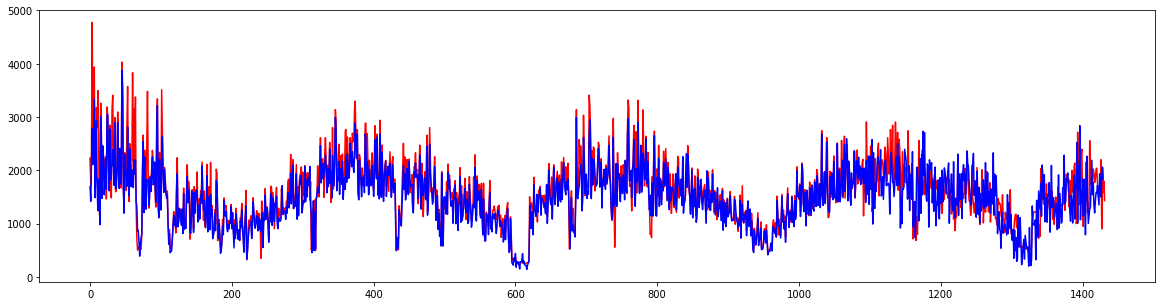

In [202]:
train_mark=[0]*(ytrain_ss.shape[0]+ytest_ss.shape[0])
y_actual = np.concatenate([ytrain_ss,ytest_ss], 0)
train_mark[int(train_ratio*len(train_mark))]=max(np.array(y_actual).flatten())
pred_all=np.concatenate([pred_train,pred_test],0)
plt.figure(figsize=(20,5)) 
plt.plot(np.array(y_actual).flatten(), 'red')
plt.plot(np.array(pred_all).flatten(),'blue')
# plt.plot(np.array(train_mark).flatten(),'lightblue')

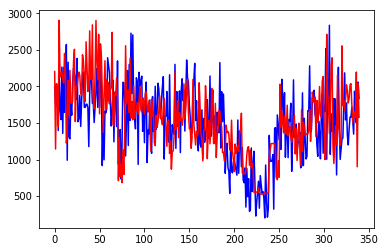

In [204]:
plt.plot(np.array(pred_test).flatten(),'blue')
plt.plot(ytest_ss[:len(pred_test)].flatten(), 'red')


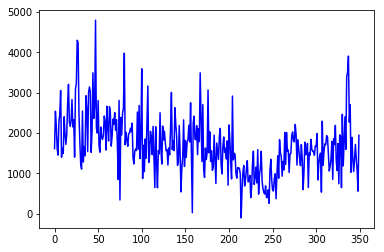

In [168]:
plt.plot(np.array(pred_test).flatten(),'blue')

In [54]:
def rmse(a,b):
    return np.sqrt(np.mean(np.square(a-b)))
#     return np.mean(np.abs(a-b))

In [203]:
rmse(np.array(ytest_ss[:len(pred_test)]).flatten(),np.array(pred_test).flatten())

479.7082588945445

In [157]:
len(np.array(pred_test))

350

In [50]:
np.sqrt(np.sum(np.square(np.array(pred_all).flatten()-np.array(y_actual).flatten()[:-4]))/len(np.array(pred_all).flatten()))

ValueError: operands could not be broadcast together with shapes (1300,) (1432,) 

In [128]:
np.array(pred_test).shape

(42, 1)

In [142]:
np.sqrt(np.sum(np.square(np.array(pred_test).flatten()-np.array(y_actual).flatten()[:-34]))/len(np.array(pred_all).flatten()))

ValueError: operands could not be broadcast together with shapes (42,) (117,) 

In [103]:
np.array(y_actual).flatten().shape

(1400,)

In [187]:
pred_all_50_smooth = smooth(np.array(pred_all).flatten(),1)

In [198]:
pred_all_90_smooth = smooth(np.array(pred_all).flatten(),1)

In [181]:
pred_all_10_smooth = smooth(np.array(pred_all).flatten(),1)

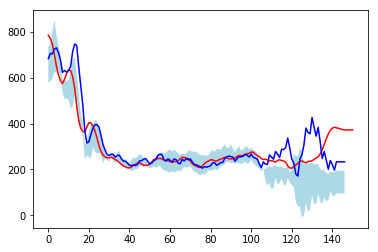

In [199]:
# plt.plot(np.array(y_actual).flatten(), 'red')
# plt.plot(smooth(pred_all_90_smooth),'lightblue')
# plt.plot(smooth(pred_all_10_smooth),'lightblue')
plt.fill_between(np.arange(len(pred_all_90_smooth)),smooth(pred_all_90_smooth), smooth(pred_all_10_smooth),facecolor='lightblue')
plt.plot(smooth(smooth(np.array(y_actual).flatten())), 'red')
plt.plot(smooth(pred_all_50_smooth),'blue')

# plt.plot(np.array(train_mark).flatten(),'black')


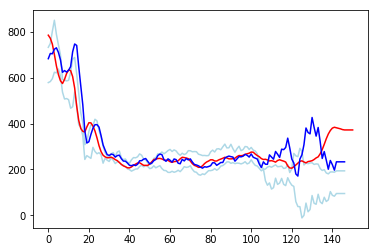

In [200]:
# plt.plot(np.array(y_actual).flatten(), 'red')
plt.plot(smooth(pred_all_90_smooth),'lightblue')
plt.plot(smooth(pred_all_10_smooth),'lightblue')
# plt.fill_between(np.arange(len(pred_all_10_smooth)),smooth(pred_all_10_smooth), smooth(pred_all_90_smooth),facecolor='lightblue')
plt.plot(smooth(smooth(np.array(y_actual).flatten())), 'red')
plt.plot(smooth(pred_all_50_smooth),'blue')

# plt.plot(np.array(train_mark).flatten(),'black')


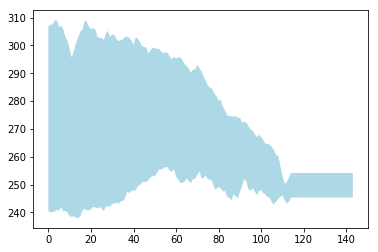

In [450]:
plt.fill_between(np.arange(len(pred_all_90_smooth)),smooth(pred_all_10_smooth,30),smooth(pred_all_90_smooth,30),facecolor='lightblue')


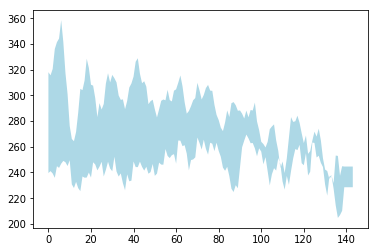

In [451]:
plt.fill_between(np.arange(len(pred_all_90_smooth)),smooth(pred_all_90_smooth), smooth(pred_all_10_smooth),facecolor='lightblue')

In [131]:
Xtrain_rf_ss= np.concatenate([Xtrain_ss.reshape([-1,window*input_size]), ytrain_his_ss], 1)
Xtest_ss_rf_ss=np.concatenate([Xtest_ss.reshape([-1,window*input_size]), ytest_his_ss], 1)
ytrain_ss_rf=ytrain_ss.flatten()
ytest_ss_rf=ytest_ss.flatten()

In [132]:
rfr = RandomForestRegressor()
rfr.fit(Xtrain_rf_ss, ytrain_ss_rf)
pred_train_rf = rfr.predict(Xtrain_rf_ss)
pred_test_rf = rfr.predict(Xtest_ss_rf_ss)

D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [133]:
train_mark_rf=[0]*(ytrain_ss_rf.shape[0]+ytest_ss_rf.shape[0])
y_actual_rf = np.concatenate([ytrain_ss_rf,ytest_ss_rf], 0)
train_mark_rf[int(train_ratio*len(train_mark))]=max(np.array(y_actual_rf).flatten())
pred_all_rf=np.concatenate([pred_train_rf,pred_test_rf],0)

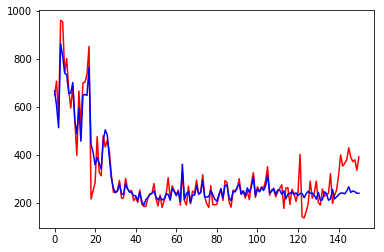

In [134]:
plt.plot(np.array(y_actual_rf).flatten(), 'red')
plt.plot(np.array(pred_all_rf).flatten(),'blue')
# plt.plot(np.array(train_mark_rf).flatten(),'lightblue')

In [135]:
np.sqrt(np.sum(np.square(np.array(pred_test_rf).flatten()-np.array(ytest_ss_rf).flatten()))/len(np.array(ytest_ss_rf).flatten()))

80.57287629235647

In [139]:
np.sqrt(np.sum(np.square(np.array(pred_all_rf).flatten()-np.array(y_actual_rf).flatten()))/len(np.array(pred_all_rf).flatten()))

57.72659961102358

In [16]:
def lossq(q, y_true, y_pred):
    d1=y_true-y_pred
    z=tf.zeros([d1.shape[0], d1.shape[1]])
    d1 = tf.concat([d1,z],axis=1)
    l1=tf.reduce_sum(q*tf.reduce_max(d1, axis=1))
    d2=y_pred-y_true
    d2 = tf.concat([d2,z],axis=1)
    l2=tf.reduce_sum((1-q)*tf.reduce_max(d2, axis=1))
    return tf.add(l1,l2)

In [5]:
def seq(input_data):
    a = tf.tanh(tf.add(tf.matmul(input_data, attn_de_linear_wt),attn_de_linear_b))
    return tf.add(tf.matmul(a, attn_de_linear_wt_1),attn_de_linear_b_1)

In [15]:
def get_air_ss_data(pop_ind, df_tot=None):
    
    def remove_nan(df_tot, col):
        df_totnn = df_tot[np.isfinite(df_tot[col])]
        return df_totnn

    if df_tot is None:
        dfs=[]
        for i in range(0,12):
            df= pd.read_csv('D:/Time_Series_Data/data_20180322.tar/data_20180322/airstation_sensor_{}.csv'.format(i), '\t')
            dfs.append(df)
        df_tot = pd.concat(dfs,axis=0)
    df_totnn=remove_nan(df_tot,'u6')
    u6_agg = df_totnn.groupby('device')['u6'].agg(len)
    u6_agg_sort = np.argsort(list(u6_agg))
    print(u6_agg.keys()[u6_agg_sort[-pop_ind]])
    df_d1 = df_totnn.loc[df_totnn['device']==u6_agg.keys()[u6_agg_sort[-pop_ind]],:]
    df_d1_dg = (pd.to_datetime(df_d1['create_datetime']).dt.dayofyear)
    df_d1['day']=list(df_d1_dg)
    df_d1_dg = df_d1.groupby('day')['u6'].agg(np.mean)
    df_d1_dg = df_d1.groupby('day')[['r9','u3','u4','u5','u6']].agg(np.mean)
    df_d1_dg = pd.DataFrame(df_d1_dg)
    
    Xdata=df_d1_dg[['r9','u3','u4','u5']]
    ydata=df_d1_dg[['u6']]
    train_size=int(train_ratio*Xdata.shape[0])
    Xtrain=Xdata.iloc[:train_size,:]
    Xtest=Xdata.iloc[train_size:,:]
    ytrain = ydata.iloc[:train_size,:]
    ytest = ydata.iloc[train_size:,:]
    
    ss=StandardScaler()
    ss.fit(Xtrain)
    Xtrain_ss= ss.transform(Xtrain)
    Xtest_ss= ss.transform(Xtest)
    
    Xtrain_ss,_=to_supervised(Xtrain_ss, window)
    Xtest_ss,_=to_supervised(Xtest_ss, window)
    ytrain_his,ytrain_ss=to_supervised(ytrain.values, window)
    ytest_his,ytest_ss=to_supervised(ytest.values, window)
    ytrain_his=ytrain_his.reshape([-1,window])
    ytest_his=ytest_his.reshape([-1,window])

    ytrain_his_ss=ytrain_his
    ytest_his_ss=ytest_his
    
    print(Xtrain_ss.shape)
    print(Xtest_ss.shape)
    print(ytrain_his_ss.shape)
    print(ytrain_ss.shape)
    print(ytest_his_ss.shape)
    print(ytest_ss.shape)
    
    return df_tot, Xtrain_ss, Xtest_ss, ytrain_his_ss, ytest_his_ss, ytrain_ss, ytest_ss

In [14]:
def get_household_data():
    df = pd.read_csv('household_power_consumption_days.csv')
    del df['datetime']
#     del df['Sub_metering_1']
#     del df['Sub_metering_2']
#     del df['Sub_metering_3']
    
    Xdata=df[['Global_reactive_power','Voltage','Sub_metering_1','Sub_metering_2','Sub_metering_3']]
    ydata=df[['Global_active_power']]
    train_size=int(train_ratio*Xdata.shape[0])
    Xtrain=Xdata.iloc[:train_size,:]
    Xtest=Xdata.iloc[train_size:,:]
    ytrain = ydata.iloc[:train_size,:]
    ytest = ydata.iloc[train_size:,:]
    
    ss=StandardScaler()
    ss.fit(Xtrain)
#     Xtrain_ss=Xtrain.values
#     Xtest_ss=Xtest.values
    Xtrain_ss= ss.transform(Xtrain)
    Xtest_ss= ss.transform(Xtest)
    
    Xtrain_ss,_=to_supervised(Xtrain_ss, window)
    Xtest_ss,_=to_supervised(Xtest_ss, window)
    ytrain_his,ytrain_ss=to_supervised(ytrain.values, window)
    ytest_his,ytest_ss=to_supervised(ytest.values, window)
    ytrain_his=ytrain_his.reshape([-1,window])
    ytest_his=ytest_his.reshape([-1,window])

    ytrain_his_ss=ytrain_his
    ytest_his_ss=ytest_his
    
    print(Xtrain_ss.shape)
    print(Xtest_ss.shape)
    print(ytrain_his_ss.shape)
    print(ytrain_ss.shape)
    print(ytest_his_ss.shape)
    print(ytest_ss.shape)
    
    return Xtrain_ss, Xtest_ss, ytrain_his_ss, ytest_his_ss, ytrain_ss, ytest_ss

In [13]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [12]:
def smooth(arr, win=5):
    mat= rolling_window(arr, win)
    smooth_arr = np.mean(mat, axis=1)
    z = np.zeros([win-1])
    z[:]=smooth_arr[-1]
    return np.concatenate([smooth_arr, z], axis=0)

In [287]:
smooth(np.array([1,2,3,4,5,6,7]))

array([3., 4., 5., 5., 5., 5., 5.])

In [11]:
def to_supervised(dvalues, window, lead_time=1):
#     dvalues = data.values
    out_arr=[]
    for i in range(dvalues.shape[0]):
        if (i+window+lead_time)<dvalues.shape[0]:
            t1 = dvalues[i:i+window,:]
            t1 = np.reshape(t1,[1,-1])
            out_arr.append(t1)
    X=np.array(out_arr).reshape([-1,window, dvalues.shape[1]])
#     yh=dvalues[window+lead_time:,:]
    y=dvalues[window:-lead_time,0].reshape([-1,1])
    return X,y